In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.close('all')


## Exemple sur données synthétiques

1. On considère ici la perte quadratique : $l(a, b) = (a - b)^2/2$. Calculer $\frac{\partial l}{\partial x_1} (a,b)$.

Soit la fonction de perte empirique $l = \frac{1}{n} \sum_{i=1}^{n} l (\hat{f}(x_i), y_i) = \frac{1}{n} \sum_{i=1}^{n} (w^T x_i - y_i)^2/2$. La dérivée $\frac{\partial l}{\partial x_1} (x,y)$ est donnée par:

$\frac{\partial l}{\partial x_1} (x,y)$ = $\frac{1}{n} \sum_{i=1}^{n} (w^T x_i - y_i) \times w_{i,1}$ 

Toutefois, l'expression d'intéret sera plutot:
$\frac{\partial l}{\partial w} (x,y)$  donnée par:
$\frac{\partial l}{\partial w} (x,y)$ = $\frac{1}{n} \sum_{i=1}^{n} (w^T x_i - y_i) x_i$ 

2. Implémenter l'algorithme SGD avec le choix d'un pas constant $\gamma$ et d'un nombre d'itérations $T$
permettant de minimiser le critère et d'aboutir à une solution correcte.

In [2]:
def stochastic_gradient1(X, y, gamma, n_iter, w_ini, loss="mse",
                        alpha=0):
    """Stochastic gradient algorithm

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size (QUESTION 5).
    n_iter : int
        The number of iterations
    w_ini : array, shape (n_features + 1,)
        The initial value of w.
    loss : str
        The type of loss function to use, e.g. "hinge" ou "mse".

    Returns
    -------
    w : array, shape (n_features + 1,)
        The final weights.
    all_w : array, shape (n_iter, n_features + 1)
        The weights across iterations.
    pobj : array, shape (n_iter,)
        The evolution of the cost function across iterations.
    """
    n_samples = X.shape[0]
    X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
    all_w = np.zeros((n_iter, w_ini.size))
    all_w[0] = w_ini
    w = w_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        idx = np.random.randint(n_samples)
        pobj[t] = 0.5 * np.mean((y - np.dot(X, w)) ** 2)
        gradient = X[idx, :] * (np.dot(X[idx], w) - y[idx]);
        w -= gamma_func(t) * gradient        
        
        all_w[t] = w
    return w, all_w, pobj

3. modèle jouet

In [3]:
# on commence par créer des données synthétiques:
n_samples = 1000
n_features = 100
X_toy = np.random.randn(n_samples, n_features)
epsilon_toy = np.random.randn(n_samples)
w_target = np.ones(n_features)
y_toy = X_toy.dot(w_target) + epsilon_toy

4. affichage de l'évolution de la loss

In [4]:
# paramètres de l'algorithme
n_iter = 10000  # number of iterations
gamma = 0.001  # suggested step size

# Initialize w with just zeros
w_ini = np.zeros(X_toy.shape[1] + 1)

# on essaie de faire tourner l'algorithme
w_toy, all_w_toy, pobj_toy \
= stochastic_gradient1(X_toy, y_toy, gamma, n_iter, w_ini, "mse", 0)
print('la valeur obtenue pour w est de: ')
print(w_toy)

la valeur obtenue pour w est de: 
[-0.046807    1.00372971  1.02994117  0.99322521  1.00799719  1.0131412
  0.96489632  1.07275388  0.94805954  0.98330466  1.03873749  0.99395924
  1.05007745  1.03199857  0.97591389  0.99570849  0.97465098  1.00404209
  1.01403935  1.05387424  1.02526292  0.97656862  1.01539905  0.96687281
  1.03772129  1.0481657   1.01671148  1.08840655  1.00155205  0.99848362
  1.0546965   1.0401626   1.01466718  0.91928219  1.01840193  0.98481031
  0.94981678  0.99689142  1.03569681  1.00179308  1.03141688  0.98971278
  0.97743237  0.98765194  1.01203318  0.95439308  0.9936333   0.99149202
  1.00784662  1.03321333  0.95766521  0.97469385  0.92702681  0.97407502
  1.00668263  0.96050115  0.97946833  1.03653543  0.97924513  0.9999388
  1.06341607  1.00333245  0.99985276  0.9628025   0.95969835  1.04291312
  1.03393611  0.95339067  0.97636607  1.02657435  1.01328668  0.97702941
  1.00274734  0.98919162  0.99709527  0.96740017  1.00218322  0.94780523
  1.02595903  0.947

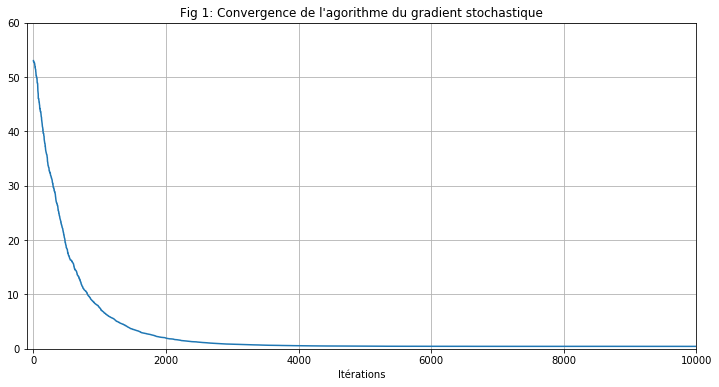

In [5]:
# traçage du graphique
fig_1 = plt.figure(figsize=(12,6))
plt.plot(pobj_toy);
plt.title('Fig 1: Convergence de l\'agorithme du gradient stochastique')
plt.xlabel('Itérations')
plt.xlim([-100,10000])
plt.ylim([0,60])
plt.grid(True)
plt.show()

5. Proposition de calibration de l'algorithme

Il apparaît qu'avec un pas de 0.001 et 5000 itérations, l'algorithme converge sans problème.

6. régularisation

Avec la régularisation, on obtient trivialement la nouvelle formule du gradient:
$\frac{\partial l}{\partial w} (x,y)$ = $\frac{1}{n} \sum_{i=1}^{n} (w^T x_i - y_i) x_i + \alpha w$ 

On modifie la fonction du gradient stochastique en conséquence:

In [6]:
def stochastic_gradient2(X, y, gamma, n_iter, w_ini, loss="mse",
                        alpha=0):
    """Stochastic gradient algorithm

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size (QUESTION 5).
    n_iter : int
        The number of iterations
    w_ini : array, shape (n_features + 1,)
        The initial value of w.
    loss : str
        The type of loss function to use, e.g. "hinge" ou "mse".

    Returns
    -------
    w : array, shape (n_features + 1,)
        The final weights.
    all_w : array, shape (n_iter, n_features + 1)
        The weights across iterations.
    pobj : array, shape (n_iter,)
        The evolution of the cost function across iterations.
    """
    n_samples = X.shape[0]
    X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
    all_w = np.zeros((n_iter, w_ini.size))
    all_w[0] = w_ini
    w = w_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        idx = np.random.randint(n_samples)
        pobj[t] = 0.5 * np.mean((y - np.dot(X, w)) ** 2)
        gradient = X[idx, :] * (np.dot(X[idx], w) - y[idx]) + alpha * w;
        w -= gamma_func(t) * gradient        
        
        all_w[t] = w
    return w, all_w, pobj

In [7]:
# paramètres de l'algorithme
n_iter = 10000  # number of iterations
gamma = 0.001  # suggested step size

# Initialize w with just zeros
w_ini = np.zeros(X_toy.shape[1] + 1)

# on essaie de faire tourner l'algorithme
w_toy, all_w_toy, pobj_toy \
= stochastic_gradient2(X_toy, y_toy, gamma, n_iter, w_ini, "mse", 0.5)
print('la valeur obtenue pour w est de: ')
print(w_toy)

la valeur obtenue pour w est de: 
[-0.25527705  0.56585393  0.82133397  0.59161301  0.63116147  0.58489276
  0.81086293  0.70100084  0.45802361  0.62957129  0.69119372  0.74822869
  0.55010977  0.72388509  0.62059471  0.77418431  0.85126375  0.54439158
  0.75683388  0.76095464  0.65644019  0.71524282  0.76164853  0.5920849
  0.67549858  0.70668297  0.60121608  0.83087196  0.72352941  0.58278898
  0.85348496  0.61688885  0.4533006   0.58497201  0.74167281  0.88300309
  0.58605615  0.73061018  0.61782458  0.70062943  0.67846029  0.80298721
  0.92188004  0.5684638   0.43768449  0.79827619  0.71555059  0.77316036
  0.70208494  0.63069318  0.58759489  0.72565754  0.73260405  0.54850669
  0.61682122  0.48906159  0.62337307  0.83461646  0.48582143  0.64761422
  0.77120431  0.61109831  0.70959719  0.75259567  0.66051209  0.93002286
  0.56565359  0.77936971  0.5551322   0.64340616  0.64830553  0.76583887
  0.54890912  0.7466315   0.67548846  0.6386352   0.70372509  0.62842473
  0.66606567  0.62

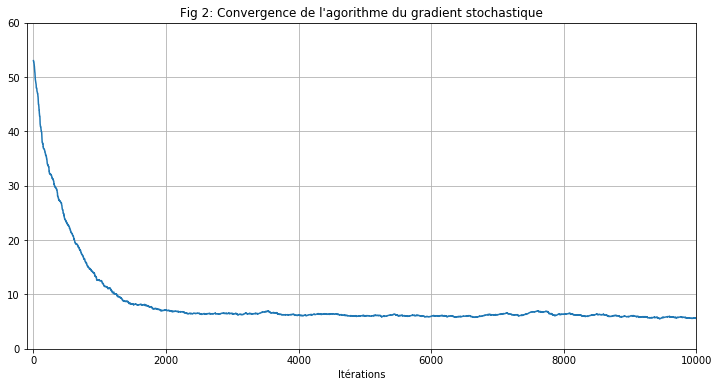

In [8]:
# traçage du graphique
fig_2 = plt.figure(figsize=(12,6))
plt.plot(pobj_toy);
plt.title('Fig 2: Convergence de l\'agorithme du gradient stochastique')
plt.xlabel('Itérations')
plt.xlim([-100,10000])
plt.ylim([0,60])
plt.grid(True)
plt.show()

7. introduction d'un pas non constant

On pose maintenant un paramètre $\gamma$ qui varie avec le nombre d'itérations:

In [9]:
def gamma(t):
    cst = 0.01
    return cst / (1 + cst * t)

la valeur obtenue pour w est de: 
[-0.05006706  1.01283271  1.02845896  1.0310246   1.0043716   0.99844235
  1.02636515  1.05579009  0.97995712  0.96633136  1.01618486  1.02497642
  1.01720021  0.9895417   0.99768462  1.04197559  1.04300526  1.00355614
  1.02390256  1.05028264  1.03564005  0.98690794  1.02698108  0.94145052
  1.03305969  1.03804662  1.07227958  1.16413804  1.00671643  1.00321156
  1.11035104  0.99824634  1.00179402  0.94814145  0.96542691  0.97585869
  0.97485771  1.02545866  1.01350089  1.00553442  1.08125181  0.99577054
  0.98941156  1.03952246  0.99307169  0.96493053  1.00714694  0.98206905
  1.03891301  1.02371771  0.96775415  0.964127    0.94677897  0.95403348
  0.98400214  0.95779922  0.96595361  1.0446213   1.01342202  0.98071315
  0.99513003  0.95604105  1.01340597  1.01016532  1.01673531  1.04153083
  1.02893587  0.97767476  1.01102968  1.03653821  0.99774071  0.99980094
  0.99155936  1.01014514  1.02125772  1.01869761  1.01829261  1.01489835
  1.07018751  0.9

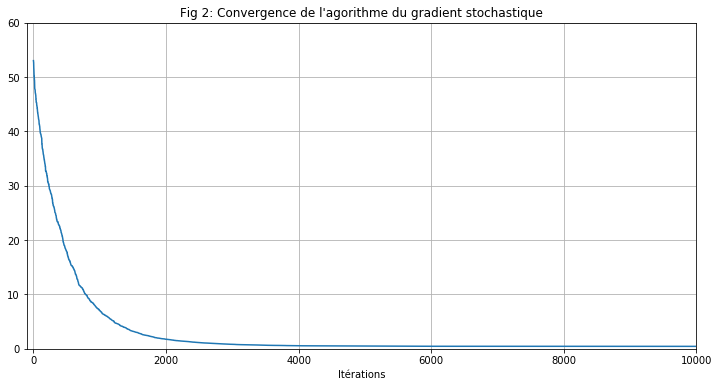

In [10]:
# paramètres de l'algorithme
n_iter = 10000  # number of iterations
gamma = 0.001  # suggested step size

# Initialize w with just zeros
w_ini = np.zeros(X_toy.shape[1] + 1)

# on essaie de faire tourner l'algorithme
w_toy, all_w_toy, pobj_toy \
= stochastic_gradient2(X_toy, y_toy, gamma, n_iter, w_ini, "mse", 0)
print('la valeur obtenue pour w est de: ')
print(w_toy)

# traçage du graphique
fig_2 = plt.figure(figsize=(12,6))
plt.plot(pobj_toy);
plt.title('Fig 2: Convergence de l\'agorithme du gradient stochastique')
plt.xlabel('Itérations')
plt.xlim([-100,10000])
plt.ylim([0,60])
plt.grid(True)
plt.show()

En théorie, on peut en effet obtenir une meilleure convergence avec un pas décroissant, car alors la fonction de perte finira par se stabiliser lorsque le pas sera proche de 0. Toutefois, cela pose le problème de le définition de la décroissance: une décroissance trop rapide pourra empêcher l'algorithme de converger si le pas tend vers 0 avant que la fonction de perte ne soit effectivmeent minimisée.

## Exemple sur données réelles

8. Base de données iris

In [11]:
# on charge les données
iris = datasets.load_iris()
X = iris.data
y = iris.target
# on les convertit en binaire
X = X[y < 2]
y = y[y < 2]
y[y == 0] = -1
X = X[:, :2]

la valeur obtenue pour w est de: 
[-0.05006706  1.01283271  1.02845896  1.0310246   1.0043716   0.99844235
  1.02636515  1.05579009  0.97995712  0.96633136  1.01618486  1.02497642
  1.01720021  0.9895417   0.99768462  1.04197559  1.04300526  1.00355614
  1.02390256  1.05028264  1.03564005  0.98690794  1.02698108  0.94145052
  1.03305969  1.03804662  1.07227958  1.16413804  1.00671643  1.00321156
  1.11035104  0.99824634  1.00179402  0.94814145  0.96542691  0.97585869
  0.97485771  1.02545866  1.01350089  1.00553442  1.08125181  0.99577054
  0.98941156  1.03952246  0.99307169  0.96493053  1.00714694  0.98206905
  1.03891301  1.02371771  0.96775415  0.964127    0.94677897  0.95403348
  0.98400214  0.95779922  0.96595361  1.0446213   1.01342202  0.98071315
  0.99513003  0.95604105  1.01340597  1.01016532  1.01673531  1.04153083
  1.02893587  0.97767476  1.01102968  1.03653821  0.99774071  0.99980094
  0.99155936  1.01014514  1.02125772  1.01869761  1.01829261  1.01489835
  1.07018751  0.9

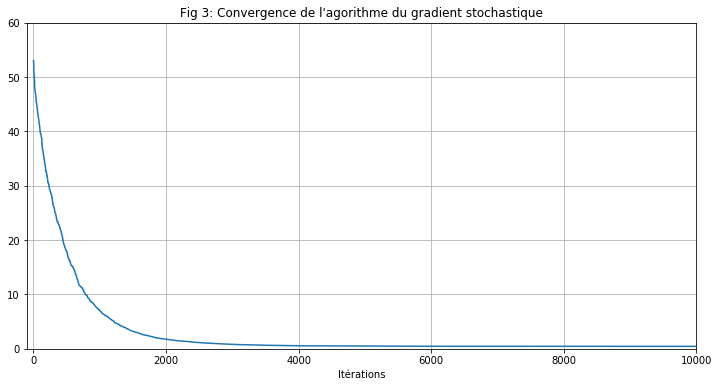

In [12]:
# paramètres de l'algorithme
n_iter = 10000  # number of iterations
gamma = 0.001  # suggested step size

# initialisation à zéro
w_ini = np.zeros(X.shape[1] + 1)

# on essaie de faire tourner l'algorithme
w, all_w, pobj \
= stochastic_gradient1(X, y, gamma, n_iter, w_ini, "mse", 0)
print('la valeur obtenue pour w est de: ')
print(w_toy)

# traçage du graphique
fig_3 = plt.figure(figsize=(12,6))
plt.plot(pobj_toy);
plt.title('Fig 3: Convergence de l\'agorithme du gradient stochastique')
plt.xlabel('Itérations')
plt.xlim([-100,10000])
plt.ylim([0,60])
plt.grid(True)
plt.show()

9. Etape de moyennage

In [13]:
def stochastic_gradient3(X, y, gamma, n_iter, w_ini, loss="mse",
                        alpha=0):

    n_samples = X.shape[0]
    X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
    sum_w = 0
    w = w_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        idx = np.random.randint(n_samples)
        pobj[t] = 0.5 * np.mean((y - np.dot(X, w)) ** 2)
        gradient = X[idx, :] * (np.dot(X[idx], w) - y[idx]);
        w -= gamma_func(t) * gradient
        sum_w += w
        
    avg_w = sum_w / t
    return w, avg_w, pobj

la valeur moyenne obtenue pour w est de: 
[-0.10766691  0.56424826 -0.95589407]


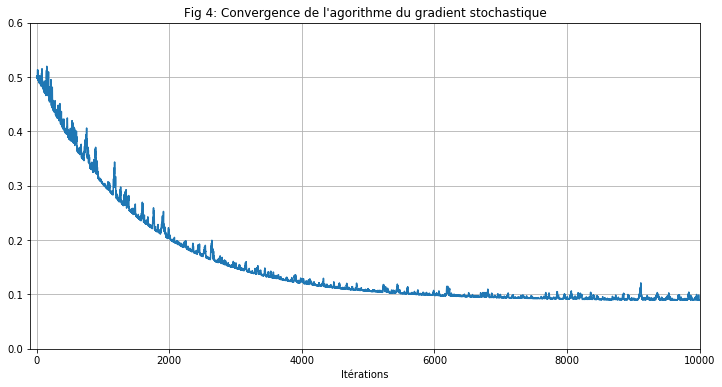

In [14]:
# paramètres de l'algorithme
n_iter = 10000  # number of iterations
gamma = 0.001  # suggested step size

# initialisation à zéro
w_ini = np.zeros(X.shape[1] + 1)

# on essaie de faire tourner l'algorithme
w, avg_w, pobj \
= stochastic_gradient3(X, y, gamma, n_iter, w_ini, "mse", 0)
print('la valeur moyenne obtenue pour w est de: ')
print(avg_w)

# traçage du graphique
fig_4 = plt.figure(figsize=(12,6))
plt.plot(pobj);
plt.title('Fig 4: Convergence de l\'agorithme du gradient stochastique')
plt.xlabel('Itérations')
plt.xlim([-100,10000])
plt.ylim([0,0.6])
plt.grid(True)
plt.show()

10. Régularisation

la valeur obtenue pour w est de: 
[-0.05006706  1.01283271  1.02845896  1.0310246   1.0043716   0.99844235
  1.02636515  1.05579009  0.97995712  0.96633136  1.01618486  1.02497642
  1.01720021  0.9895417   0.99768462  1.04197559  1.04300526  1.00355614
  1.02390256  1.05028264  1.03564005  0.98690794  1.02698108  0.94145052
  1.03305969  1.03804662  1.07227958  1.16413804  1.00671643  1.00321156
  1.11035104  0.99824634  1.00179402  0.94814145  0.96542691  0.97585869
  0.97485771  1.02545866  1.01350089  1.00553442  1.08125181  0.99577054
  0.98941156  1.03952246  0.99307169  0.96493053  1.00714694  0.98206905
  1.03891301  1.02371771  0.96775415  0.964127    0.94677897  0.95403348
  0.98400214  0.95779922  0.96595361  1.0446213   1.01342202  0.98071315
  0.99513003  0.95604105  1.01340597  1.01016532  1.01673531  1.04153083
  1.02893587  0.97767476  1.01102968  1.03653821  0.99774071  0.99980094
  0.99155936  1.01014514  1.02125772  1.01869761  1.01829261  1.01489835
  1.07018751  0.9

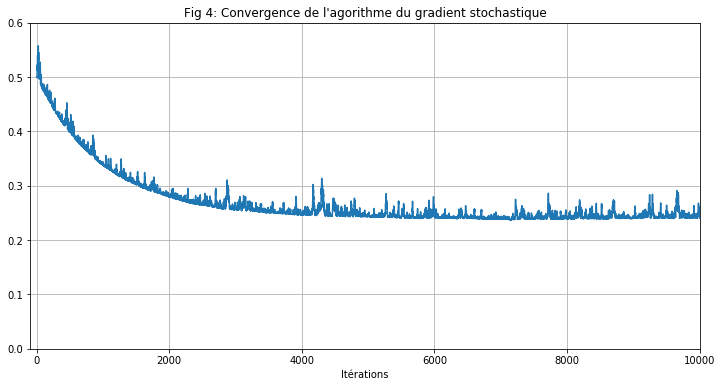

In [15]:
# paramètres de l'algorithme
n_iter = 10000  # number of iterations
gamma = 0.001  # suggested step size

# initialisation à zéro
w_ini = np.zeros(X.shape[1] + 1)

# on essaie de faire tourner l'algorithme
w, all_w, pobj \
= stochastic_gradient2(X, y, gamma, n_iter, w_ini, "mse", 0.5)
print('la valeur obtenue pour w est de: ')
print(w_toy)

# traçage du graphique
fig_4 = plt.figure(figsize=(12,6))
plt.plot(pobj);
plt.title('Fig 4: Convergence de l\'agorithme du gradient stochastique')
plt.xlabel('Itérations')
plt.xlim([-100,10000])
plt.ylim([0,0.6])
plt.grid(True)
plt.show()

11. Hinge loss

In [16]:
def stochastic_gradient4(X, y, gamma, n_iter, w_ini, loss="hinge",
                        alpha=0):
    n_samples = X.shape[0]
    X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
    all_w = np.zeros((n_iter, w_ini.size))
    all_w[0] = w_ini
    w = w_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        idx = np.random.randint(n_samples)
        pobj[t] = np.mean(np.maximum(0, 1 - y * np.dot(X, w)))
        gradient = -y[idx] * X[idx] * [1 - y[idx] * np.dot(X[idx], w) > 0]
        w -= gamma_func(t) * gradient       
        
        all_w[t] = w
    return w, all_w, pobj

la valeur obtenue pour w est de: 
[-0.344   1.5522 -2.6392]


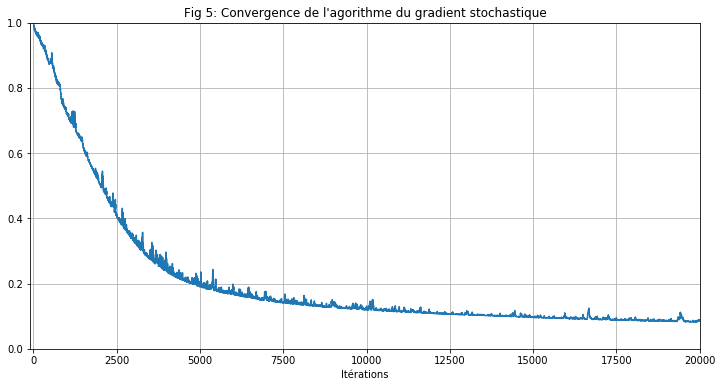

In [17]:
# paramètres de l'algorithme
n_iter = 20000  # number of iterations
gamma = 0.001  # suggested step size

# initialisation à zéro
w_ini = np.zeros(X.shape[1] + 1)

# on essaie de faire tourner l'algorithme
w, all_w, pobj \
= stochastic_gradient4(X, y, gamma, n_iter, w_ini, "hinge", 0.5)
print('la valeur obtenue pour w est de: ')
print(w)

# traçage du graphique
fig_5 = plt.figure(figsize=(12,6))
plt.plot(pobj);
plt.title('Fig 5: Convergence de l\'agorithme du gradient stochastique')
plt.xlabel('Itérations')
plt.xlim([-100,20000])
plt.ylim([0,1])
plt.grid(True)
plt.show()

On note que la convergence est sensiblement plus lente qu'avec la loss quadratique.

12. Utilisation de Scikit Learn

In [49]:
clf = linear_model.SGDClassifier(loss="hinge", max_iter=20000, eta0=0.001, learning_rate="constant", \
                                 alpha=0.5, penalty='l2')
clf.fit(X, y)
coeffs = np.append(clf.intercept_,clf.coef_)
print('coeffs with homemade SGD are ', w)
print('coeffs with Scikit Learn SGD are ', coeffs)

coeffs with homemade SGD are  [-0.344   1.5522 -2.6392]
coeffs with Scikit Learn SGD are  [-0.104       0.44928922 -0.68145961]


The coefficients are quite similar with the two methodologies (up to a scaling factor, normal for hyperplanes).